In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

# Load data

In [2]:
data1 = sio.loadmat('Salinas_corrected.mat')#load .mat file
data2 = sio.loadmat('Salinas_gt.mat')#load .mat file
print(data1.keys())
print(data2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'salinas_gt'])


In [3]:
salinas_img = data1['salinas_corrected']#choose 'salinas_corrected' value in Salinas_corrected.mat dictionary
salinas_labels = data2['salinas_gt']#choose 'salinas_gt' value in Salinas_gt.mat dictionary

In [4]:
print("Salinas shape: {}".format(salinas_img.shape))

Salinas shape: (512, 217, 204)


Text(0.5, 1.0, 'Salinas labels')

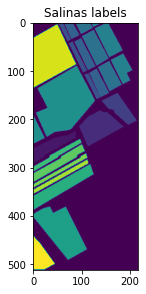

In [5]:
# Display ground truth for each image
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.imshow(salinas_labels, cmap='viridis')
plt.title('Salinas labels')

# Plot the curve of one sample

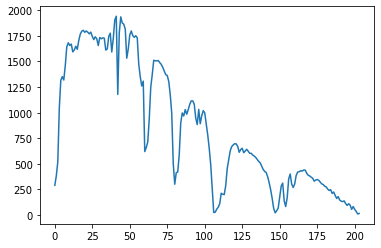

In [6]:
# get any position 
pos = [0,1]
feature = salinas_img[pos[0],pos[1],:]
plt.plot(feature)

# Data count of each class

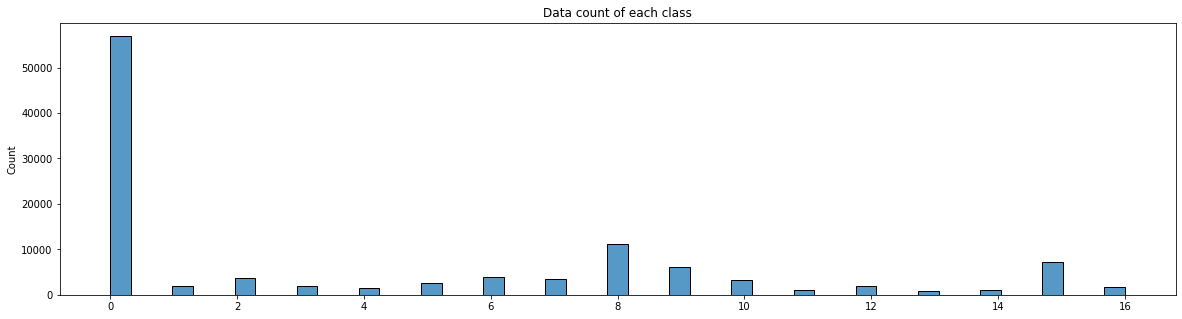

In [7]:
plt.figure(figsize=(20,5))
ax_salinas = sns.histplot(salinas_labels.flatten())
plt.title("Data count of each class")
plt.show()

In [8]:
X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
y_gt = salinas_labels.ravel()
print("Salinas shape: {}".format(X_salinas.shape))


Salinas shape: (111104, 204)


# Remove the background

In [9]:
#delete the zero label(background)
X_salinas_reduced = np.delete(X_salinas, np.where(y_gt == 0), axis = 0)
y = np.delete(y_gt, np.where(y_gt == 0))

In [10]:
#Data after removing the background
print(X_salinas_reduced.shape)

(54129, 204)


# PCA

In [11]:
#this function is from "tools.py" in "https://github.com/drguigui1/HSI-Classification/blob/7702cd8266853165ff7e62e36fc2d907846c7269/src/7%20-%20Random_forest_classifier.ipynb"
#choose the main feartures using PCA
print("Fitting the PCA")
pca_model = PCA()
pca_model.fit(X_salinas_reduced)
var_cumsum = pca_model.explained_variance_ratio_.cumsum()
n_components_salinas = len(var_cumsum[var_cumsum <= 0.997])
print("Number of components Salinas:")
print(n_components_salinas) 

Fitting the PCA
Number of components Salinas:
3


In [12]:
pca_model = PCA(n_components = n_components_salinas)
pca_model.fit(X_salinas_reduced)
X_salinas_reduced_pca = pca_model.transform(X_salinas_reduced)
print(X_salinas_reduced_pca.shape)

(54129, 3)


# Rescale the data into range (0,1)

In [13]:
# setup the MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0, 1))
# Normalization: transform the dataset into the range [0,1]
X_salinas_01 = scaler.fit_transform(X_salinas_reduced_pca)

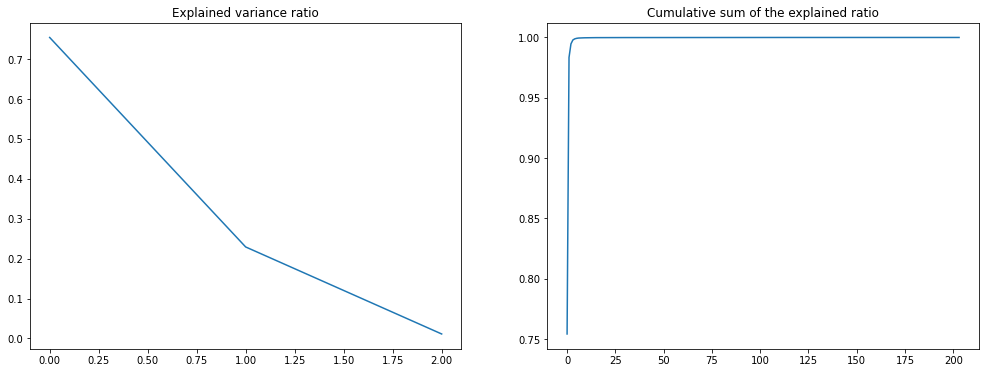

In [14]:
#this function is from "notebook.py" from https://notebooks.githubusercontent.com/view/ipynb?browser=edge&color_mode=auto&commit=fae244fbe6dd08dc1a4d336dc326b05a84429197&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4c69306e4d6f3073652f6879706572737065637472616c5f696d6c2f666165323434666265366464303864633161346433333664633332366230356138343432393139372f50726f6a6563742e6970796e62&logged_in=true&nwo=Li0nMo0se%2Fhyperspectral_iml&path=Project.ipynb&platform=windows&repository_id=360174211&repository_type=Repository&version=96#load-data
plt.figure(figsize=(17,6))
plt.subplot(1, 2, 1)
plt.plot(pca_model.explained_variance_ratio_[:10])
plt.title("Explained variance ratio")

plt.subplot(1, 2, 2)
plt.title("Cumulative sum of the explained ratio")
plt.plot(var_cumsum)
plt.show()

# Split data into train / test

Using 75% of the data as the training dataset and 25% for the testing.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_salinas_01, y, test_size=0.25, random_state=42)

In [16]:
print("Train shape: {}".format(X_train.shape))
print("Train labels shape: {}".format(y_train.shape))
print("Test shape: {}".format(X_test.shape))
print("Test labels shape: {}".format(y_test.shape))

Train shape: (40596, 3)
Train labels shape: (40596,)
Test shape: (13533, 3)
Test labels shape: (13533,)


# Grouping data by different labels

In [17]:
class_list = []
for i in range(16):
    label_idx = np.argwhere(y_train == i+1).flatten()
    class_i = X_train[label_idx]
    class_list.append(class_i)

In [18]:
def get_log_likelihood_grid(train):
    log_liklelihood = [
        [
            norm(weight_guess, error_guess).logpdf(train).sum()
            for weight_guess in WEIGHT_GUESSES
        ]
        for error_guess in ERROR_GUESSES
    ]
    return np.asarray(log_liklelihood)

In [19]:
def get_mle(train):
    log_likelihood = get_log_likelihood_grid(train)
    idx = np.argwhere(log_likelihood == log_likelihood.max())[0][1]
    return WEIGHT_GUESSES[idx]

In [20]:
WEIGHT_GUESSES = np.linspace(0.3, 0.5, 10)
ERROR_GUESSES = np.linspace(0.01, 0.1, 10)

In [21]:
#Get mu and cov of each dataset
mu=[]
cov=[]
for i in range (16):
    mu.append(np.mean(class_list[i],0))    
    cov.append(np.cov(class_list[i],rowvar= False))

In [22]:
def cal_multi_normals(X_test,mu, cov):
    '''
    compute data x's  probabilitiw of three Gaussian models 
    '''
    y=np.zeros((X_test.shape[0],16))
    for i in range(16):
        
        y1 = multivariate_normal.pdf(X_test, mu[i], cov[i])
        y[:,i]=y1
    maximum_class = np.argmax(y,axis=1)+1
    
    return maximum_class

In [23]:
pred_result = cal_multi_normals(X_test, mu, cov)

In [24]:
print(pred_result.shape)
print(pred_result)

(13533,)
[ 2  5  9 ... 11  8  8]


In [25]:
total_preds_salinas_score = accuracy_score(y_test, pred_result)

In [26]:
print(total_preds_salinas_score)

0.8530259365994236


The comparison histogram of predicted labels and expected labels

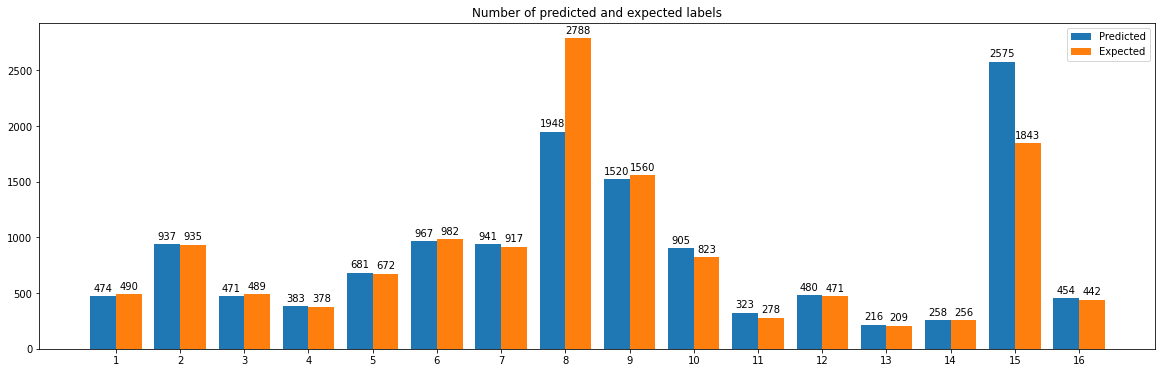

In [27]:
#this function is from "plot.py" in "https://github.com/drguigui1/HSI-Classification/blob/7702cd8266853165ff7e62e36fc2d907846c7269/src/7%20-%20Random_forest_classifier.ipynb"
fig, axs = plt.subplots(figsize=(20, 6))

bar_x, bar_count_pred = np.unique(pred_result, return_counts=True)
bar1 = axs.bar(bar_x - 1.2, bar_count_pred, 0.4, label="Predicted")

bar_x, bar_count_exp = np.unique(y_test, return_counts=True)
bar2 = axs.bar(bar_x - 0.8, bar_count_exp, 0.4, label="Expected")

title='Number of predicted and expected labels'

axs.bar_label(bar1, padding=3)
axs.bar_label(bar2, padding=3)

axs.set_xticks(np.arange(len(bar_x)))
axs.set_xticklabels(bar_x)

axs.set_title(title)
axs.legend()
plt.show()

Predict the total data

In [28]:
total_preds_salinas = cal_multi_normals(X_salinas_01,mu,cov)

Final performance of this model

In [29]:
#accuracy
total_preds_salinas_score = accuracy_score(y, total_preds_salinas)
print("The final accuracy of this model is {}".format(total_preds_salinas_score))

The final accuracy of this model is 0.8546065879657855


In [30]:
#mean square error
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y, total_preds_salinas))

6.0727890779434315


In [31]:
#precision,recall,f1-score
from sklearn.metrics import classification_report
print(classification_report(y, total_preds_salinas))

              precision    recall  f1-score   support

           1       1.00      0.98      0.99      2009
           2       0.99      0.99      0.99      3726
           3       0.96      0.91      0.93      1976
           4       0.99      1.00      0.99      1394
           5       0.93      0.95      0.94      2678
           6       1.00      0.99      0.99      3959
           7       0.96      0.97      0.96      3579
           8       0.81      0.57      0.67     11271
           9       0.99      0.97      0.98      6203
          10       0.79      0.85      0.82      3278
          11       0.85      0.98      0.91      1068
          12       0.97      1.00      0.98      1927
          13       0.96      0.98      0.97       916
          14       0.93      0.93      0.93      1070
          15       0.57      0.80      0.66      7268
          16       0.86      0.89      0.87      1807

    accuracy                           0.85     54129
   macro avg       0.91   

# Result visualization

In [32]:
#Establish the index of 16 labels 
idx = np.argwhere(salinas_labels.flatten() != 0).flatten()

In [33]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
#Passing prediction data into an image
salinas_preds_img[idx] = total_preds_salinas
salinas_preds_img = salinas_preds_img.reshape(((salinas_img.shape[0], salinas_img.shape[1])))

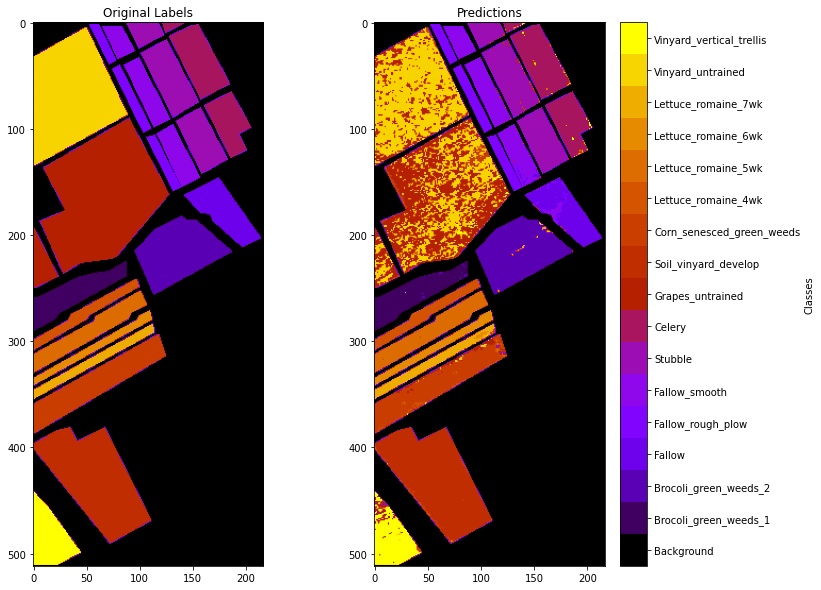

In [34]:
global GROUND_TRUTH
global NUM_CLASSES
#Establishe the name of labels
GROUND_TRUTH = ['Background', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow',
                        'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop',
                        'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk',
                        'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
NUM_CLASSES = len(GROUND_TRUTH) - 1

plt.figure(figsize=(12,10))

plt.subplot(1, 2, 1)
plt.title('Original Labels')
plt.imshow(salinas_labels,cmap='gnuplot')

plt.subplot(1, 2, 2)
plt.title('Predictions')
plt.imshow(salinas_preds_img,cmap='gnuplot')

cbar = plt.colorbar(label='Classes', boundaries=(np.arange(NUM_CLASSES + 2) - 0.5))
cbar.set_ticks(np.arange(NUM_CLASSES + 1))
cbar.set_ticklabels(GROUND_TRUTH)
plt.show()